# ERNIE DPO Best Practices

# 1 Introduction to DPO  
### 1.1 What is DPO
DPO (Direct Preference Optimization) is a method to optimize language models using human preference data, aiming to align model outputs more closely with human expectations. It bypasses the reward model training and reinforcement learning steps found in traditional RLHF (Reinforcement Learning from Human Feedback). The training data must include both positive examples (desired outputs) and negative examples (undesired outputs).

### 1.2 Applicability of DPO
- ✅ Applicable
  - Behavioral alignment, aligning with human preferences and values. For example, making responses more friendly, polite, or safe;
  - For open-ended questions with non-unique answers (such as content creation, summarization, or dialogue), enabling the model to learn more nuanced and popular ways of expression;
  - Enforcing specific constraints or formats. For instance, encouraging the model to provide shorter responses.

- ❌ Not Applicable
  - Adding new internalized knowledge to the model;
  - Forcing the model to acquire capabilities it does not possess;
  - Fully correcting inherent biases in pre-trained models;
  - Tasks with a single correct answer (such as strict mathematical calculations).

### 1.3 General Steps for DPO
1. Construct evaluation data and criteria, test the model's baseline capabilities, and analyze its shortcomings and issues.
2. Conduct thorough prompt engineering.
3. Determine if DPO is applicable; prepare training data.
4. Train the model. Design training parameters based on task characteristics and data conditions. Key parameters to focus on include:
    - Batch size
    - Number of training epochs or maximum training steps
    - Learning rate type and initial value
    - Warm-up steps
5. Evaluate the results. Use the same evaluation data and criteria to assess the model's performance after training. If the results are unsatisfactory, consider further optimizing the training data or adjusting the training parameters.

# 2 Best Practice Task Introduction
### 2.1 Task Description
We have observed that in some scenarios, the model's responses are quite lengthy. We aim to make the model's responses shorter and more concise.

### 2.2 Data Source
We use the DPO demo dataset provided by the popular open-source community project LlamaFactory ([link](https://huggingface.co/datasets/llamafactory/DPO-En-Zh-20k/tree/main)). This dataset contains 1,000 entries each in Chinese and English, formatted in ShareGPT style, with the following fields:
- `conversations`: Dialogue context, in the format `[{"from": "", "value": ""}]`, where the `from` field includes:
  - `system`: System prompt
  - `human`: User input
  - `gpt`: Model input (here, `gpt` is used to represent the large model dialogue assistant)
- `chosen`: Positive example (desired output)
- `rejected`: Negative example (undesired output)
> In real-world scenarios, we typically construct better data based on the model's current output to form training samples. However, for the purpose of demonstrating the DPO process in this tutorial, we directly downloaded the open-source dataset.

### 2.3 Evaluation Criteria
We focus on the length of the output, so we can evaluate the model's performance using the mean and median of the string length.

### 2.4 Experimental Environment
This tutorial uses the following environment:
- 1x 80GB A800 GPU
- CUDA Version: 12.3
- CUDA Driver: 525.125.06
- nvcc: 12.3
- gcc: 12.2
- Python Version: 3.10.12

### 2.5 Dependencies
- **ERNIEKit**: A toolchain for ERNIE large models, covering the full process of training, compression, and inference for the ERNIE 4.5 series models. Based on PaddlePaddle framework v3.1, it supports training on various mainstream domestic chips.
- **ERNIEKit WebUI**: A visual interface supporting training, dialogue interaction, performance evaluation, model export, and more. [Documentation](../../docs/cli_webui_usage.md)
- **[Optional] visualdl**: A tool for visualizing loss and other metrics, already included in ERNIEKit.
- **ERNIEKit inference scripts**.
- **Python dependencies** used in this tutorial.

In [1]:
# The Python dependencies
import json
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

RANDOM_SEED = 2025

# 3 Data Preprocessing

### 3.1 Preparing Raw Data
First, download the open-source dataset and save it to `cookbook/data/llamafactory_dpo_en_10k.json`.  

![dpo_download_dataset_en](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_download_dataset_en.png)

To facilitate processing, we convert the ShareGPT format to the ERNIE DPO format here. We have defined several data preprocessing functions for this purpose.

In [2]:
def conversations_to_ernie_data(conversations):
    system = ""
    src = []
    tgt = []
    for conversation in conversations:
        if conversation.get("from", "") == "system":
            system = conversation.get("value", "")
        elif conversation.get("from", "") == "human":
            src.append(conversation.get("value", ""))
        elif conversation.get("from", "") == "gpt":
            tgt.append(conversation.get("value", ""))
    return system, src, tgt


def is_valid_ernie_data(data):
    if len(data["src"]) == 0:
        return False
    if len(data["response"][0]) == 0 or len(data["response"][1]) == 0:
        return False
    return True

Call the above functions to process the data.

In [3]:
raw_data_path = "../data/llamafactory_dpo_en_10k.json"
ernie_data_path = raw_data_path.replace(".json", "_ernie_format.jsonl")

with open(raw_data_path, "r") as fin:
    with open(ernie_data_path, "w") as fout:
        data_list = json.load(fin)
        for data in data_list:
            system, src, tgt = conversations_to_ernie_data(data.get("conversations", []))
            chosen = data.get("chosen", {}).get("value", "")
            rejected = data.get("rejected", {}).get("value", "")
            ernie_data = {
                "system": system,
                "src": src,
                "tgt": tgt,
                "response": [[chosen], [rejected]],
                "sort": [1, 0],
            }  # The smaller value in 'sort' represents 'rejected', while the larger value represents 'chosen'
            if is_valid_ernie_data(ernie_data):
                fout.write(json.dumps(ernie_data, ensure_ascii=False) + "\n")

### 3.2 Analyzing Raw Data
Observe the length distribution of `chosen` and `rejected` in the dataset, then construct the test set and training set accordingly.

In [4]:
chosen_len_cnt = defaultdict(int)
rejected_len_cnt = defaultdict(int)

with open(ernie_data_path, "r") as fin:
    for line in fin:
        data = json.loads(line)
        chosen_len = len(data["response"][0][0])
        rejected_len = len(data["response"][1][0])
        chosen_len_cnt[chosen_len] = chosen_len_cnt.get(chosen_len, 0) + 1
        rejected_len_cnt[rejected_len] = rejected_len_cnt.get(rejected_len, 0) + 1

Perform a simple visualization analysis.

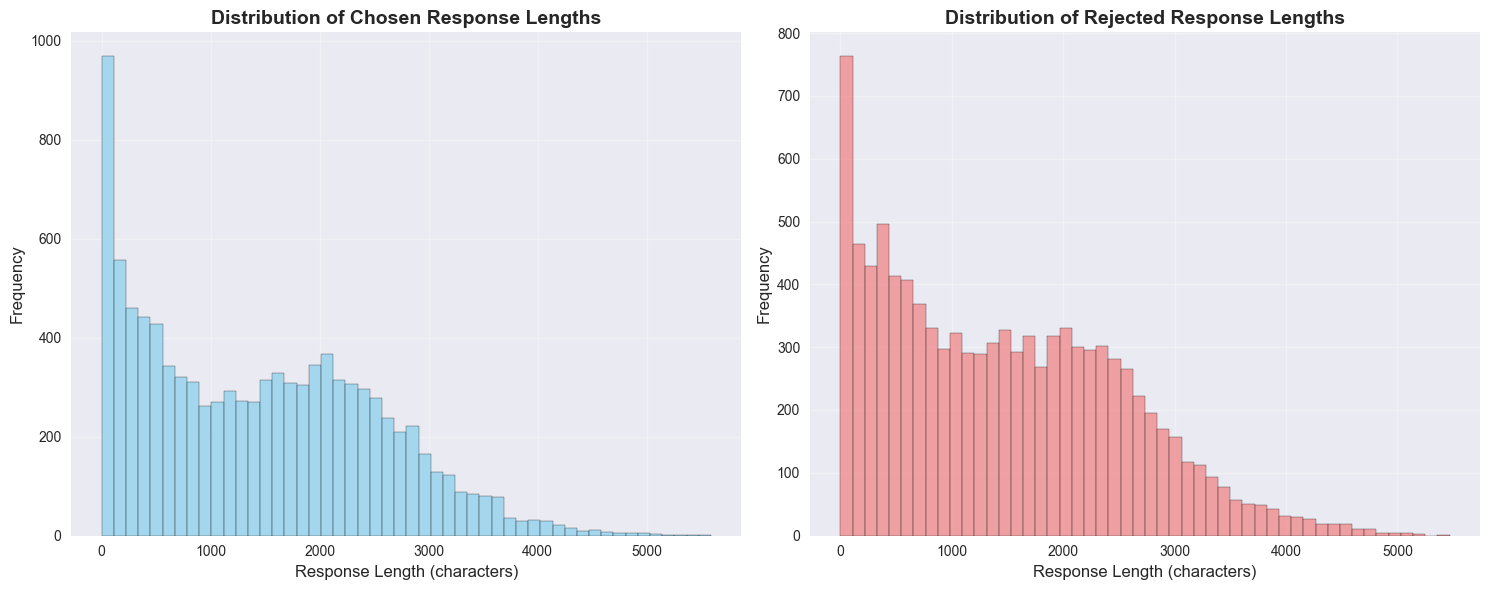

Chosen responses - Mean length: 1447.0, Median length: 1371.5
Rejected responses - Mean length: 1468.3, Median length: 1355.5
Total chosen responses: 9998
Total rejected responses: 9998


In [5]:
# Set the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Use two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distribution of chosen response lengths
chosen_lengths = list(chosen_len_cnt.keys())
chosen_counts = list(chosen_len_cnt.values())

ax1.hist(chosen_lengths, weights=chosen_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Chosen Response Lengths', fontsize=14, fontweight='bold')
ax1.set_xlabel('Response Length (characters)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot the distribution of rejected response lengths
rejected_lengths = list(rejected_len_cnt.keys())
rejected_counts = list(rejected_len_cnt.values())

ax2.hist(rejected_lengths, weights=rejected_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Distribution of Rejected Response Lengths', fontsize=14, fontweight='bold')
ax2.set_xlabel('Response Length (characters)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Use pandas Series to directly calculate statistics
chosen_series = pd.Series([length for length, count in chosen_len_cnt.items() for _ in range(count)])
rejected_series = pd.Series([length for length, count in rejected_len_cnt.items() for _ in range(count)])

# Display statistical information
print(f"Chosen responses - Mean length: {chosen_series.mean():.1f}, Median length: {chosen_series.median():.1f}")
print(f"Rejected responses - Mean length: {rejected_series.mean():.1f}, Median length: {rejected_series.median():.1f}")
print(f"Total chosen responses: {len(chosen_series)}")
print(f"Total rejected responses: {len(rejected_series)}")

### 3.3 Evaluating Model Baseline Capabilities
Define evaluation criteria.

In [11]:
def evaluate_dpo_model(testset_path):
    output_lens = []
    with open(testset_path, "r") as fin:
        for line in fin:
            data = json.loads(line.strip())
            if data[-1].get("role", "") == "bot":
                output_lens.append(len(data[-1].get("content", "")))
    return sum(output_lens) / len(output_lens), sorted(output_lens)[len(output_lens) // 2]

Construct the test set. We randomly sample 200 entries from the raw data and convert them to OpenAI API format as the test set.

In [12]:
def ernie_data_to_openai_api_format(data, keep_system: bool = True):
    openai_data = []
    if keep_system and data.get("system", ""):
        openai_data.append({"role": "system", "content": data.get("system", "")})
    if len(data["src"]) == 1:
        openai_data.append({"role": "user", "content": data["src"][0]})
    else:
        for i in range(len(data["src"]) - 1):
            openai_data.append({"role": "user", "content": data["src"][i]})
            openai_data.append({"role": "assistant", "content": data["tgt"][i]})
        openai_data.append({"role": "user", "content": data["src"][-1]})
    return openai_data

In [13]:
testset_path = "../data/dpo_testset.jsonl"
random.seed(RANDOM_SEED)

with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    test_data = random.sample(data_list, 200)
    # We noticed that some system prompts in the raw data require the model to deliberately output long text (e.g., 'Must generate a detailed and lengthy response'),
    # which may affect the model's performance, so we do not retain the system prompt
    test_data = [ernie_data_to_openai_api_format(data, keep_system=False) for data in test_data]

with open(testset_path, "w", encoding="utf-8") as fout:
    for item in test_data:
        fout.write(json.dumps(item, ensure_ascii=False) + "\n")

Use the original model to infer the test set. Currently, the WebUI does not support inferring test sets, so we use the inference scripts from the ERNIEKit codebase for this operation.
- **Script**: `tools/inference/scripts/infer.sh`
- **Set key hyperparameters**:
  - `top_p=0.7`
  - `temperature=0.7`
  - `max_seq_len=128000` (ERNIE-4.5-0.3B supports dynamic 128K context length)
  - `max_dec_len=8192` (since this task focuses on the model's output length, avoid actively truncating the model's output)
  - `weight_quantize_algo` Remove this line if quantization was not used during training

> Inference process omitted

Calculate evaluation metrics.

In [ ]:
# Get inference results
dpo_infer_path = "../data/infer/dpo_03b_exp0.jsonl"
raw_model_output_len_mean, raw_model_output_len_median = evaluate_dpo_model(dpo_infer_path)
print("Original Model")
print(f"Output Length Mean: {raw_model_output_len_mean:.1f}, Median: {raw_model_output_len_median}")

### 3.4 Making Training Set
How to construct it most effectively? Generally, the `rejected` in the training set is the actual output of the model to be optimized, while `chosen` is the optimized result based on this output. Here, we directly use the `rejected` and `chosen` from the open-source dataset. It’s not hard to think of two basic approaches to constructing the training set: one is where `rejected` is close to the output length of the original model on the test set and `rejected` is significantly longer than `chosen`; the other does not consider the output length of the original model on the test set, as long as `rejected` is significantly longer than `chosen`.

In [ ]:
# Training Set 1: rejected length close to the original model
with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    trainset_1 = []
    for data in data_list[201:]:
        chosen = data["response"][0]
        rejected = data["response"][1]
        # Use the mean as a reference, allowing a certain range of deviation
        if (
            abs(len(rejected) - raw_model_output_len_mean) < raw_model_output_len_mean * 0.4
            and len(rejected) > len(chosen) * 1.2
        ):
            trainset_1.append(data)

print(f"Training Set 1 sample size: {len(trainset_1)}")
print(
    f"Average length of rejected in Training Set 1: {sum(len(d['response'][1]) for d in trainset_1) / len(trainset_1):.1f}"
)

In [37]:
# Training Set 2: rejected significantly longer than chosen
with open(ernie_data_path, "r") as fin:
    data_list = [json.loads(line) for line in fin]
    trainset_2 = []
    for data in data_list[201:]:
        chosen = data["response"][0]
        rejected = data["response"][1]
        if len(rejected) > len(chosen) * 1.2:
            trainset_2.append(data)

print(f"Training Set 2 sample size: {len(trainset_2)}")
print(
    f"Average length of rejected in Training Set 2: {sum(len(d['response'][1]) for d in trainset_2) / len(trainset_2):.1f}"
)

Control variables to ensure the sample sizes of the two training sets are the same.

In [38]:
random.seed(RANDOM_SEED)
trainset_2 = random.sample(trainset_2, len(trainset_1))

print(f"Training Set 2 sample size: {len(trainset_2)}")
print(
    f"Average length of rejected in Training Set 2: {sum(len(d['response'][1]) for d in trainset_2) / len(trainset_2):.1f}"
)

Export the training sets.

In [39]:
trainset_1_path = "../data/dpo_trainset_exp1.jsonl"
trainset_2_path = "../data/dpo_trainset_exp2.jsonl"

# We noticed that some system prompts in the raw data require the model to deliberately output long text (e.g., 'Must generate a detailed and lengthy response'),
# which may affect the model's performance, so we do not retain the system prompt
with open(trainset_1_path, "w") as fout:
    for data in trainset_1:
        del data["system"]
        fout.write(json.dumps(data, ensure_ascii=False) + "\n")

with open(trainset_2_path, "w") as fout:
    for data in trainset_2:
        del data["system"]
        fout.write(json.dumps(data, ensure_ascii=False) + "\n")

# 4 Training
### 4.1 Choosing the Base Model
Considering the convenience of demonstration and the complexity of the task, we choose the smaller-sized ERNIE-4.5-0.3B model.

### 4.2 Designing Training Parameters
Designing training parameters relies heavily on experience.

### 4.3 Training with WebUI
1. Start the WebUI in the root directory of the ERNIEKit project: `erniekit webui`  
2. Configure the model path and export directory  

![dpo_set_path](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_set_path_en.png)

3. Set full-parameter/LoRA fine-tuning, numerical precision, etc.  

![dpo_lora_set](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_set_lora_en.png)

4. Set the fine-tuning mode (SFT/DPO) and configure training parameters  

![dpo_train_params](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_train_params_en.png)

5. Configure the training set and validation set

<div style="display: flex; justify-content: space-around;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_trainset_en.png" alt="dpo_trainset" style="width: 49%;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_validset_en.png" alt="dpo_validset" style="width: 49%;">
</div>

### 4.4 Viewing Training Logs and Loss Curves
Training log path: `${your_model_dir}/paddle_dist_log/workerlog.0`. You can also run the following command to view the loss curve:
```bash
visualdl --logdir ${your_model_dir}/vdl_log --host 0.0.0.0
```

### 4.5 Merging Model Weights (Only Required for LoRA Fine-Tuning)
You can conveniently merge model weights in the 'Evaluation' mode of the WebUI   

![dpo_merge_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/dpo_merge_lora_en.png)

# 5 Performance Evaluation

### 5.1 Calculating Evaluation Metrics
The evaluation criteria have been defined above, and the method for calculating evaluation metrics has been demonstrated. We will not repeat the process here, but instead present the training configurations and evaluation metrics of several experiments for readers' reference.

| Experiment No. | Training Set | Training Parameters | ↓ Output Length Mean | ↓ Output Length Median |
| --- | --- | --- | --- | --- |
| 0 | - | - | 888.8 | 515 |
| 1 | • len(rejected) close to original model<br>• len(rejected) >= 1.2 len(chosen)<br>• 614Q | max_steps=614<br>warmup_steps=50<br>global_batch_size=1 | 879.5 | 442 |
| 2 | • len(rejected) >= 1.2 len(chosen)<br>• 614Q | max_steps=614<br>warmup_steps=50<br>global_batch_size=1 | 864.7 | 354 |

### 5.2 Analyzing Experimental Results
It can be seen that under the same training parameters, Training Set 2 is more effective. This naturally leads to the question: if we include more training data and make the length difference between `rejected` and `chosen` more significant, would the model's performance improve further? We designed a third set of experiments, and the results are as follows:

| Experiment No. | Training Set | Training Parameters | ↓ Output Length Mean | ↓ Output Length Median |
| ---- | ---- | ---- | ---- | ---- |
| 0 | - | - | 888.8 | 515 |
| 1 | len(rejected) close to original model <br> len(rejected) >= 1.2 len(chosen) <br> 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 879.5 | 442 |
| 2 | len(rejected) >= 1.2 len(chosen) <br> 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | <ins>**864.7**</ins> | <ins>**354**</ins> |
| 3 | len(rejected) >= 2 len(chosen) <br> 1804Q | max_steps=1804 <br> warmup_steps=50 <br> global_batch_size=1 | 1145.1 | 412 |

Unfortunately, the model's performance worsened. We have the following hypotheses:  
1. Insufficient warm-up. Based on general experience, setting warm-up to 10% of max_steps might be better.  
2. Too few max_steps.  

To address these two hypotheses, we designed a fourth set of experiments. The results are as follows:

| Experiment No. | Training Set | Training Parameters | ↓ Output Length Mean | ↓ Output Length Median |
| ---- | ---- | ---- | ---- | ---- |
| 0 | - | - | 888.8 | 515 |
| 1 | • len(rejected) close to original model <br> • len(rejected) >= 1.2 len(chosen) <br> • 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 879.5 | 442 |
| 2 | • len(rejected) >= 1.2 len(chosen) <br> • 614Q | max_steps=614 <br> warmup_steps=50 <br> global_batch_size=1 | 864.7 | 354 |
| 3 | • len(rejected) >= 2 len(chosen) <br> • 1804Q | max_steps=1804 <br> warmup_steps=50 <br> global_batch_size=1 | 1145.1 | 412 |
| 4 | • len(rejected) >= 2 len(chosen) <br> • 1804Q | max_steps=3608 <br> warmup_steps=360 <br> global_batch_size=1 | <ins>**628.1**</ins> | <ins>**331**</ins> |

It can be seen that the fourth set of experiments achieved more desirable results!

### 5.3 Catastrophic Forgetting
We attempted to test whether the model's performance on general tasks declined (exhibiting a 'forgetting phenomenon'). The good news is that 'forgetting' is not significant. For example:
> Input: [{"role": "user", "content": "Please remember, your name is Sponge"}, {"role": "assistant", "content": "Okay, I am Sponge"}, {"role": "user", "content": "Who are you?"}]  

> ERNIE-4.5-0.3B Original Model Output: I am Sponge, a super curious and fun guy! Is there anything you'd like to chat about?  
> DPO Model Output: I am Sponge, a psychic warrior exploring the sponge world!